# Lecture 06: Statistical Analysis

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JamesMTucker/DATA_340_NLP/blob/master/Notebooks/Lecture_06_2023_02_14.ipynb)

Objective:

* Upcoming Assignments
* Some notes about this weeks reading
* Review Shannon's Entropy (Scipy package)
* Term-frequency inverse document frequency
* GitHub Questions

## Review of Shannon Entropy: Lecture 05 Notebook

[Open](Lecture_05_2023_02_09.ipynb#Shannon's-Entropy)

## Readings

### Martin & Jurafsky

[Link](https://github.com/JamesMTucker/DATA_340_NLP/blob/master/course_readings/Jurafsky_Martin_chapter_2_12-38.pdf)

### Grimmer et al.

[Link](https://github.com/JamesMTucker/DATA_340_NLP/blob/master/course_readings/Grimmer-Grimmer_48-62.pdf)

## TF-IDF: Term-Frequency Inverse Document Frequency

We learned from our analysis of Zipf's law that the most frequently occuring terms (bag of words) offer little information about how topics are discussed. We can get some idea of what topics might be discussed by the frequencies of a given term. But we often want and need to do more to analyze a document and its language. So, we created N-grams. We saw that an N-gram methodology provides more information about how language was used in a document, and we discussed how we could use entropy to analyse the bigrams in relationship to all the bigrams in a document. In addition to entropy, there are other useful metrics to extract a document's relevant terms: Term-frequency inverse document frequency and Pointwise Mutual Information.

### Informal Definition

General intuition of tf-idf is that words isolated to one particular text provide information as to how it relates to other documents in the corpus.

It is import to note the following definitions:

* `Document` = a news article, journal article, tweet, reddit post, etc.
* `Document vocabulary` = frequency of terms in a document
* `Corpus` = a collection of documents
* `Corpus Vocabulary` = frequency of terms in a corpus of documents

Thus,

`tf-idf` = `term_frequency` * `inverse_document_frequency`

`term_frequency` = count of a words appearence in a document
`inverse_document_frequency` = log(total_number_of_documents / number_of_documents_with_term) + 1

### Formal Definition

$$idf_{t} = log_{10}(\frac{N}{df_t})$$

`term frequency` = $tf_{t,d} = log_{10}(count(t,d) + 1)$ -- The intuition is that a word appearing 100 times does not make that word 100x more likely to be relevant to the meanining of the document. Therefore, we give a heigher weight to words that occur only in a few documents.

`total documents in collection` = $idf_{t} = log_{10}(\frac{N}{df_t})$ -- We let _N_ be the total number of documents in the corpus

### Case Study I

#### Corpus Creation

In [1]:
# We will use a database of conversations about Eczema
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# If you are running this notebook in Google colab, uncomment this line of code and run
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)
# file = Path('gdrive/MyDrive/DATA_340_3_NLP/Datasets/eczema.csv')
# convos = pd.read_csv(file)

convos = pd.read_csv('./data/eczema.csv')

In [3]:
# Let's see the general data types used
convos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199537 entries, 0 to 199536
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   docID   199537 non-null  int64 
 1   text    199537 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.0+ MB


In [4]:
# Let's Random Sample some conversations
convos.sample(n=10)

,docID,text
48172,58526,yup i forgot to mention that i wa originally w...
144922,193545,thanks for your word advice yeah it s really n...
110889,145837,maybe try using only the tiniest amount i don ...
91071,118115,i get usually eczema mainly on my hand and now...
95990,124974,you can t even put your face on a pillow witho...
24279,27043,i dont know how to phrase this so im just gunn...
90325,117072,good luck having a break out on the face is a ...
9822,11436,zyrtec or generic our allergist told u our lo ...
140327,187231,i m so sorry and i hope thing get better over ...
73478,93350,i ve been thinking of buying some baby lotion ...


In [5]:
# Let's get an idea of the data size
convos.shape

(199537, 2)

In [6]:
# Let's work with a subset
random_seed = 42
convos = convos.sample(n=100, random_state=1)
convos

,docID,text
69663,88168,phd run clinical trial in controlled study the...
71980,91326,interesting maybe that s what s happened to me...
115848,152826,damn op if this random person didn t even know...
81307,104353,i m glad that you re good now i ve been put on...
134825,179615,it definitely helped im noticing some puffines...
...,...,...
173492,231386,for me it been the opposite lost 35lbs and i e...
171015,228239,well i know that oral and topical steroid make...
104039,136286,i d recommend aloe vera on your heated area on...
73948,94021,anything with chili is a no go for me heard ab...


#### Exploratory Data Analysis

Let's get more familiar with our data

In [7]:
# Let's get an understanding of the length of our conversations
convos['word_total'] = convos['text'].apply(lambda x: len(x.split(' ')))
convos

,docID,text,word_total
69663,88168,phd run clinical trial in controlled study the...,34
71980,91326,interesting maybe that s what s happened to me...,82
115848,152826,damn op if this random person didn t even know...,39
81307,104353,i m glad that you re good now i ve been put on...,66
134825,179615,it definitely helped im noticing some puffines...,22
...,...,...,...
173492,231386,for me it been the opposite lost 35lbs and i e...,63
171015,228239,well i know that oral and topical steroid make...,106
104039,136286,i d recommend aloe vera on your heated area on...,111
73948,94021,anything with chili is a no go for me heard ab...,32


<AxesSubplot: ylabel='Frequency'>

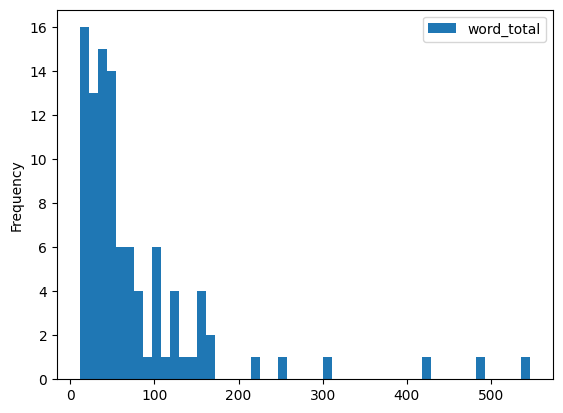

In [8]:
# Our sample distribution conversation length
(convos
 .drop(columns=['docID', 'text'])
 .plot(kind='hist', bins=50)
)

In [9]:
# We can find the shortest and longest conversation using the min and max methods
convos['word_total'].max(), convos['word_total'].min()

(547, 11)

In [10]:
# Explore the longest and shortest
convos[convos['word_total'] == convos['word_total'].max()]['text'].values

array(['i m 9 day removed from a severe eczema crisis that wa so awful it felt and looked like i wa in the dying process it had spread like wildfire in a matter of day all over my body including on my face and neck this wa following 2 month of chronic almost constant weeping eczema the most vile and disgusting aspect of this disease once i wa able to get the weeping to stop my skin resembled that of a burn victim very much looking like raw hamburger meat layer of skin seemingly had been burned off i think this wa the ultimate skin meltdown following tsw and withdrawal from 4 year use of oral immunosuppressing drug what i learned over the past month seems to have been responsible for turning the corner i went to a highly regarded allergist immunologist and discovered myself to be a highly allergic person for the first time in the 5 year i have had eczema i wa put on antihistamine to quell the itch i take allegra in the morning and zyrtec in the afternoon and evening this made a huge dif

In [11]:
convos.query('word_total > 300')

,docID,text,word_total
23242,25954,so i m pretty sure i ve developed eczema at th...,302
20419,22990,hi r eczema i have been a lurker for a while a...,424
180911,241060,i m 9 day removed from a severe eczema crisis ...,547
28611,31950,so my worst flare up for several year occurred...,490


In [12]:
f"The 95th percentile of the tweet lenght is: {np.percentile(convos['word_total'].tolist(), 95)} words"

'The 95th percentile of the tweet lenght is: 223.29999999999993 words'

#### Standardize our corpus

Let's analyze the above two datasets using TF-IDF by doing the following.

* Tokenize the conversation
* We can try stemming the tweet and not-stemming to see the difference
* Count the freqeuncy of words in each tweet

In [13]:
# Tokenize the tweet using SpaCy
import spacy
import string

from tqdm import tqdm
tqdm.pandas()

punctuation = list(string.punctuation)
NLP = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [14]:
# Let's get a list of the lemmas to count the frequency of words but remove the punctuation
convos['tokens'] = convos['text'].progress_apply(lambda x: [x.lemma_.lower() for x in NLP(x) if x.lemma_.lower() not in punctuation])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 375.31it/s]


In [15]:
convos

,docID,text,word_total,tokens
69663,88168,phd run clinical trial in controlled study the...,34,"[phd, run, clinical, trial, in, control, study..."
71980,91326,interesting maybe that s what s happened to me...,82,"[interesting, maybe, that, s, what, s, happen,..."
115848,152826,damn op if this random person didn t even know...,39,"[damn, op, if, this, random, person, didn, t, ..."
81307,104353,i m glad that you re good now i ve been put on...,66,"[i, m, glad, that, you, re, good, now, i, ve, ..."
134825,179615,it definitely helped im noticing some puffines...,22,"[it, definitely, help, i, m, notice, some, puf..."
...,...,...,...,...
173492,231386,for me it been the opposite lost 35lbs and i e...,63,"[for, i, it, be, the, opposite, lose, 35lb, an..."
171015,228239,well i know that oral and topical steroid make...,106,"[well, i, know, that, oral, and, topical, ster..."
104039,136286,i d recommend aloe vera on your heated area on...,111,"[i, d, recommend, aloe, vera, on, your, heated..."
73948,94021,anything with chili is a no go for me heard ab...,32,"[anything, with, chili, be, a, no, go, for, i,..."


In [16]:
# Unwind the data on the tokens
convos_tokens = (convos
                  .explode('tokens')
                  .drop(columns=['text', 'word_total'])
                )

In [17]:
convos_tokens

,docID,tokens
69663,88168,phd
69663,88168,run
69663,88168,clinical
69663,88168,trial
69663,88168,in
...,...,...
156933,209645,good
156933,209645,skin
156933,209645,keep
156933,209645,up


#### Word frequency

In [18]:
# create a word frequency dataframe
term_frequency = (convos_tokens
                  .groupby(by=['docID', 'tokens'])
                  .agg({'tokens': 'count'})
                  .rename(columns={'tokens': 'term_frequency'})
                  .reset_index()
                  .rename(columns={'tokens': 'term'})
                 )

In [19]:
term_frequency

,docID,term,term_frequency
0,5577,a,1
1,5577,about,1
2,5577,after,1
3,5577,and,1
4,5577,away,1
...,...,...,...
5088,263096,to,4
5089,263096,try,1
5090,263096,wash,1
5091,263096,what,1


In [20]:
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
         'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
         'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
         'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
         'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
         'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 've', 'll', 'amp']

In [21]:
# remove stop words
term_frequency = term_frequency.drop(term_frequency[term_frequency['term'].isin(stop_words)].index)
term_frequency

,docID,term,term_frequency
4,5577,away,1
5,5577,boat,1
6,5577,check,1
7,5577,cleanse,1
8,5577,face,1
...,...,...,...
5082,263096,start,1
5085,263096,think,1
5087,263096,throughout,1
5089,263096,try,1


#### Document frequency

In [22]:
# Document Frequency
document_frequency = (term_frequency
                      .groupby(['docID', 'term'])
                      .size()
                      .unstack()
                      .sum()
                      .reset_index()
                      .rename(columns={0: 'document_frequency'})
                     )

In [23]:
document_frequency

,term,document_frequency
0,0,2.0
1,00,1.0
2,1,4.0
3,10,4.0
4,10min,1.0
...,...,...
1389,yet,5.0
1390,young,1.0
1391,yup,2.0
1392,zealand,1.0


In [24]:
# merge the document freqs into the term dataframe
term_frequency = term_frequency.merge(document_frequency)

#### Corpus count

In [25]:
documents_in_corpus = term_frequency['docID'].nunique()
documents_in_corpus

100

In [26]:
# inverse document frequency
term_frequency['idf'] = np.log((1 + documents_in_corpus) / (1 + term_frequency['document_frequency'])) + 1

In [27]:
term_frequency

,docID,term,term_frequency,document_frequency,idf
0,5577,away,1,4.0,4.005683
1,16684,away,1,4.0,4.005683
2,128783,away,1,4.0,4.005683
3,234438,away,1,4.0,4.005683
4,5577,boat,1,1.0,4.921973
...,...,...,...,...,...
3227,263096,arm,1,1.0,4.921973
3228,263096,diagnose,1,1.0,4.921973
3229,263096,mostly,1,1.0,4.921973
3230,263096,recently,1,1.0,4.921973


#### TF-IDF Calculation

In [28]:
term_frequency['tfidf'] = term_frequency['term_frequency'] * term_frequency['idf']
term_frequency.sort_values(by=['term_frequency'], ascending=False)

,docID,term,term_frequency,document_frequency,idf,tfidf
1001,22990,product,11,6.0,3.669210,40.361314
787,241060,wa,9,25.0,2.357024,21.213216
221,241060,eczema,8,32.0,2.118613,16.948904
2028,31950,tacrolimus,8,1.0,4.921973,39.375787
2647,241060,topical,7,3.0,4.228826,29.601783
...,...,...,...,...,...,...
1202,22116,lately,1,1.0,4.921973,4.921973
1203,22116,leathery,1,1.0,4.921973,4.921973
1204,22116,leg,1,1.0,4.921973,4.921973
1205,22116,lot,1,12.0,3.050171,3.050171


#### Normalize with sklearn

In [29]:
from sklearn import preprocessing
term_frequency['tfidf_norm'] = preprocessing.normalize(term_frequency[['tfidf']], axis=0, norm='l2')

In [30]:
term_frequency

,docID,term,term_frequency,document_frequency,idf,tfidf,tfidf_norm
0,5577,away,1,4.0,4.005683,4.005683,0.013059
1,16684,away,1,4.0,4.005683,4.005683,0.013059
2,128783,away,1,4.0,4.005683,4.005683,0.013059
3,234438,away,1,4.0,4.005683,4.005683,0.013059
4,5577,boat,1,1.0,4.921973,4.921973,0.016046
...,...,...,...,...,...,...,...
3227,263096,arm,1,1.0,4.921973,4.921973,0.016046
3228,263096,diagnose,1,1.0,4.921973,4.921973,0.016046
3229,263096,mostly,1,1.0,4.921973,4.921973,0.016046
3230,263096,recently,1,1.0,4.921973,4.921973,0.016046


In [31]:
top_n_terms = term_frequency.sort_values(by=['docID', 'tfidf'], ascending=[True, False]).groupby(['docID']).head(2)

In [32]:
top_n_terms.head(10)

,docID,term,term_frequency,document_frequency,idf,tfidf,tfidf_norm
78,5577,moisturizer,2,8.0,3.417896,6.835792,0.022286
140,5577,work,2,16.0,2.781907,5.563814,0.018139
338,5924,people,3,12.0,3.050171,9.150513,0.029832
254,5924,know,3,15.0,2.842532,8.527595,0.027801
519,6445,child,2,4.0,4.005683,8.011365,0.026118
498,6445,year,2,8.0,3.417896,6.835792,0.022286
537,10843,allergen,1,2.0,4.516508,4.516508,0.014725
546,10843,dermatologist,1,5.0,3.823361,3.823361,0.012465
611,12473,5,3,5.0,3.823361,11.470083,0.037394
605,12473,0,2,2.0,4.516508,9.033016,0.029449


In [34]:
docIds = top_n_terms['docID'].tolist()

In [35]:
convos[convos['docID'] == 5924]['text'].values

array(['hi everyone i am new to these forum but i did sign up a while ago i had to end up reregistering but thats irrelevant it s been so nice reading story from other people who suffer too i don t know many people that have eczema so it relieving to read thing that make me think i m not alone i ve had it my whole life 20 year and know it s hard trying to express the feeling and frustration to people who don t know the sensation of eczema and constant itching anyway i don t want this to come across a spam but i m actually at university studying graphic design and have decided to do an independent project on eczema awareness and the psychological effect behind eczema it would mean so so much if you took a minute of your time to fill out this quick questionnaire thanks so much oh and happy new year'],
      dtype=object)

### Case Study II

In [36]:
# We can use sklearn
# R - https://cran.r-project.org/web/packages/superml/vignettes/Guide-to-TfidfVectorizer.html

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
convos = pd.read_csv('./data/eczema.csv')
convos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199537 entries, 0 to 199536
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   docID   199537 non-null  int64 
 1   text    199537 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.0+ MB


In [38]:
random_seed = 42
convos = convos.sample(n=100, random_state=1)
convos

,docID,text
69663,88168,phd run clinical trial in controlled study the...
71980,91326,interesting maybe that s what s happened to me...
115848,152826,damn op if this random person didn t even know...
81307,104353,i m glad that you re good now i ve been put on...
134825,179615,it definitely helped im noticing some puffines...
...,...,...
173492,231386,for me it been the opposite lost 35lbs and i e...
171015,228239,well i know that oral and topical steroid make...
104039,136286,i d recommend aloe vera on your heated area on...
73948,94021,anything with chili is a no go for me heard ab...


#### Calculate tf-idf


In [39]:
# Create an instance of the Tfidf vectorizer with stopwords

tfidf_vectorizer = TfidfVectorizer(stop_words='english')

#### Fit our model to the data

In [40]:
# Fit on our model

vectors = tfidf_vectorizer.fit_transform(convos['text'])

#### Convert our trained model to a dataframe

In [41]:
# Create dataframe with terms and tfidf
tfidf_df = pd.DataFrame(vectors.toarray(), index=convos.index.values, columns=tfidf_vectorizer.get_feature_names_out())
# tfidf_df.loc['00_Document Frequency'] = (tfidf_df > 0).sum()

In [42]:
tfidf_vectorizer.get_feature_names_out().tolist()

['00',
 '0oz',
 '10',
 '10min',
 '12',
 '14',
 '15',
 '19',
 '19th',
 '20',
 '2013',
 '29',
 '30',
 '30g',
 '33',
 '34',
 '35lbs',
 '38',
 '3x',
 '45',
 '75',
 '80',
 '80oz',
 '87',
 '89',
 '9am',
 '9pm',
 'able',
 'absolutely',
 'absorb',
 'absorbed',
 'absorbs',
 'absorption',
 'absurd',
 'abuse',
 'accidentally',
 'accurate',
 'ache',
 'acne',
 'act',
 'active',
 'activity',
 'actually',
 'acv',
 'ad',
 'add',
 'added',
 'addiction',
 'addition',
 'advanced',
 'advice',
 'advocate',
 'affect',
 'affected',
 'affordable',
 'afraid',
 'afternoon',
 'afterward',
 'age',
 'agent',
 'aggressive',
 'ago',
 'ahhh',
 'aid',
 'ain',
 'album',
 'alcohol',
 'allegra',
 'allergen',
 'allergic',
 'allergist',
 'allergy',
 'alleviating',
 'allowed',
 'aloe',
 'amazing',
 'america',
 'amp',
 'angle',
 'ankle',
 'answer',
 'antibiotic',
 'antihistamine',
 'anxiety',
 'anybody',
 'anymore',
 'apparent',
 'appeared',
 'apple',
 'application',
 'apply',
 'applying',
 'appointment',
 'approve',
 'aquap

#### Explore some selected terms

In [44]:
# Explore some selected terms

tfidf_df[['eczema', 'lotion', 'skin', 'sleep', 'pain', 'zyrtec', 'afraid', 'dehydration', 'dermatologist']]

,eczema,lotion,skin,sleep,pain,zyrtec,afraid,dehydration,dermatologist
69663,0.089646,0.0,0.093679,0.0,0.0,0.0,0.0,0.000000,0.0
71980,0.089905,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
115848,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
81307,0.000000,0.0,0.094006,0.0,0.0,0.0,0.0,0.000000,0.0
134825,0.154354,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
173492,0.222882,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
171015,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
104039,0.000000,0.0,0.059160,0.0,0.0,0.0,0.0,0.000000,0.0
73948,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


#### Create Heatmap of TF-IDF Terms in our data

In [45]:
# Let's create a heatmap of higest terms in some of the documents

tfidf_df = (tfidf_df
            .stack()
            .reset_index()
            .rename(columns={0: 'tfidf', 'level_0': 'docID', 'level_1': 'term'})
           )

In [57]:
# Group the documents by their n highest performing terms

n = 2
top_tfidf = (tfidf_df
             .sort_values(by=['docID','tfidf'], ascending=[True,False])
             .groupby(['docID'])
             .head(n)
            )

In [58]:
top_tfidf

,docID,term,tfidf
129064,5134,moisturizers,0.465886
129666,5134,work,0.288712
26857,5459,people,0.247118
26629,5459,know,0.241113
24720,5945,child,0.440428
...,...,...,...
46939,193642,moved,0.234561
61239,195722,life,0.379809
61295,195722,matter,0.363415
20844,198114,itch,0.335628


In [59]:
#!pip install altair

In [60]:
# Import altair for graphing the n highest terms in a heatmap

import altair as alt

# adding a little randomness to break ties in term ranking
top_tfidf_rand = top_tfidf.copy()
top_tfidf_rand['tfidf'] = top_tfidf_rand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001

base = alt.Chart(top_tfidf_rand).encode(
    x = 'rank:O',
    y = 'docID:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["docID"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + text).properties(width = 800)

alt.LayerChart(...)

In [51]:
# Let's read one
convos.loc[105467]['text']

'oops i didn t reply directly to this haha so see my other comment also wanted to add that when we do give allergy med it doe not get rid of the rash however it doe help him to stop scratching another thing we do when he is in a bad break out is a bleach bath then one night no bath then an epsom salt bath then skip a night then bleach bath then we give his skin a few day before another bath on average we only bathe him 2 3 time a week'

## GitHub Questions